In [1]:
!unzip hw5_part_two_release.zip

Archive:  hw5_part_two_release.zip
  inflating: data/questions-words.txt  
  inflating: data/definitional_pairs.json  
  inflating: data/equalize_pairs.json  
  inflating: data/gender_specific_full.json  
  inflating: data/profession_words.json  
  inflating: hw5_part2.ipynb         
  inflating: hw5_part1.py            
  inflating: hw5_part1_utils.py      
  inflating: hw5_part2.py            
  inflating: hw5_part3.py            
  inflating: adult.npz               
  inflating: homework.pdf            


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import hw5_part1_utils

from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import numpy as np

from tqdm import tqdm

Written Exercise 4 code

In [8]:
# YOUR IMPLEMENTATION FOR THE SHADOW MODEL ATTACK GOES HERE ###################


def synthesize_attack_data(
    target_model: hw5_part1_utils.TargetModel,
    shadow_data: np.ndarray,
    shadow_labels: np.ndarray,
    num_shadow_models: int = 4
):
    """Synthesize attack data.

    Arguments:

        target_model {TargetModel} -- an instance of the TargetModel class;
          behaves as a keras model but additionally has a train_shadow_model
          function, which takes a subset of the shadow data and labels and
          returns a model with identical architecture and hyperparameters to
          the original target model, but that is trained on the given shadow
          data.

        shadow_data {np.ndarray} -- data available to the attack to train
          shadow models. If the arget model's training set is size N x D,
          shadow_data is 2N x D.

        shadow_labels {np.ndarray} -- the corresponding labels to the
          shadow_data, given as a numpy array of 2N integers in the range 0 to
          C where C is the number of classes.

        num_shadow_models {int} -- the number of shadow models to use when
          constructing the attack model's dataset.

    Returns: three np.ndarrays; let M = 2N * num_shadow_models

        attack_data {np.ndarray} [M, 2C] -- shadow data label probability and
           label one-hot

        attack_classes {np.ndarray} [M, 1 of {0,1,...,C-1}] -- shadow data
           labels

        attack_labels {np.ndarray} [M, 1 of {0,1}] -- attack data labels
           (training membership)

    """

    C = shadow_labels.max() + 1

    attack_data: np.ndarray = None
    attack_classes: np.ndarray = None
    attack_labels: np.ndarray = None

    # SOLUTION
    # raise NotImplementedError('You need to implement this.')

    in_data = []
    out_data = []
    shadow_data_classes = []

    for i in tqdm(
        range(num_shadow_models),
        desc="training shadow models",
        unit="split"
    ):

        split = hw5_part1_utils.DataSplit(shadow_labels, seed=i)

        shadow_model = target_model.train_shadow_model(
            shadow_data[split.in_idx], shadow_labels[split.in_idx],
            # shadow_data[split.out_idx], shadow_labels[split.out_idx]
            # validation data
        )

        in_pred = shadow_model.predict(shadow_data[split.in_idx])
        in_onehot = to_categorical(
            shadow_labels[split.in_idx], C
        )
        in_data.append(np.concatenate(
            (in_pred, in_onehot),
            axis=1)
        )

        out_pred = shadow_model.predict(shadow_data[split.out_idx])
        out_onehot = to_categorical(
            shadow_labels[split.out_idx], C
        )
        out_data.append(np.concatenate(
            (out_pred, out_onehot),
            axis=1)
        )
        shadow_data_classes.append(shadow_labels[split.in_idx])
        shadow_data_classes.append(shadow_labels[split.out_idx])

    in_data = np.concatenate(in_data)
    out_data = np.concatenate(out_data)

    attack_data = np.concatenate((in_data, out_data))

    attack_labels = np.concatenate((
        np.ones(len(in_data)),
        np.zeros(len(out_data)))
    )

    attack_classes = np.concatenate(shadow_data_classes)

    ###

    return attack_data, attack_classes, attack_labels


def build_attack_models(
    target_model: hw5_part1_utils.TargetModel,
    shadow_data: np.ndarray,
    shadow_labels: np.ndarray,
    num_shadow_models: int = 4,
    batch_size=2048,
    epochs=32
):
    """Build attacker models.

    Arguments:

        target_model {TargetModel} -- an instance of the TargetModel class;
          behaves as a keras model but additionally has a train_shadow_model
          function, which takes a subset of the shadow data and labels and
          returns a model with identical architecture and hyperparameters to
          the original target model, but that is trained on the given shadow
          data.

        shadow_data {np.ndarray} -- data available to the attack to train
          shadow models. If the arget model's training set is size N x D,
          shadow_data is 2N x D.

        shadow_labels {np.ndarray} -- the corresponding labels to the
          shadow_data, given as a numpy array of 2N integers in the range 0 to
          C where C is the number of classes.

        num_shadow_models {int} -- the number of shadow models to use when
          constructing the attack model's dataset.

    Returns:

        {tuple} -- a tuple of C keras models, where the c^th model predicts the
        probability that an instance of class c was a training set member.

    """

    attack_data, attack_classes, attack_labels = \
        synthesize_attack_data(
            target_model,
            shadow_data,
            shadow_labels,
            num_shadow_models=4
        )

    # to return
    attack_models: Tuple[Model] = None

    C = shadow_labels.max() + 1

    # SOLUTION
    # raise NotImplementedError('You need to implement this.')

    # Define the attack model architecture.
    # def get_attack_model_architecture_1():
    #     attack_x = Input((2 * C,))
    #     attack_y = Dense(128, activation='relu')(attack_x)
    #     attack_y = Dense(64, activation='relu')(attack_y)
    #     attack_y = Dense(32, activation='relu')(attack_y)
    #     attack_y = Dense(10, activation='relu')(attack_y)
    #     attack_y = Dense(1, activation='sigmoid')(attack_y)

    #     attack_model = Model(attack_x, attack_y)

    #     attack_model.compile(
    #         optimizer='adam',
    #         loss='binary_crossentropy',
    #         metrics=['accuracy']
    #     )

    #     return attack_model

        # Define the attack model architecture.
    def get_attack_model_architecture_2():
        attack_x = Input((2 * C,))
        attack_y = Dense(4 * C, activation='relu')(attack_x)
        attack_y = Dense(1, activation='sigmoid')(attack_y)

        attack_model = Model(attack_x, attack_y)

        attack_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return attack_model

        # Define the attack model architecture.
    # def get_attack_model_architecture_3():
    #     attack_x = Input((2 * C,))
    #     attack_y = Dense(128, activation='relu')(attack_x)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(64, activation='relu')(attack_y)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(32, activation='relu')(attack_y)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(32, activation='relu')(attack_y)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(1, activation='sigmoid')(attack_y)

    #     attack_model = Model(attack_x, attack_y)

    #     attack_model.compile(
    #         optimizer='adam',
    #         loss='binary_crossentropy',
    #         metrics=['accuracy']
    #     )

    #     return attack_model
    
    #     # Define the attack model architecture.
    # def get_attack_model_architecture_4():
    #     attack_x = Input((2 * C,))
    #     attack_y = Dense(20, activation='relu')(attack_x)
    #     attack_y = Dense(16, activation='relu')(attack_x)
    #     attack_y = Dense(12, activation='relu')(attack_x)
    #     attack_y = Dense(8, activation='relu')(attack_x)
    #     attack_y = Dense(4, activation='relu')(attack_x)
    #     attack_y = Dense(2, activation='relu')(attack_x)
    #     attack_y = Dense(1, activation='sigmoid')(attack_y)

    #     attack_model = Model(attack_x, attack_y)

    #     attack_model.compile(
    #         optimizer='adam',
    #         loss='binary_crossentropy',
    #         metrics=['accuracy']
    #     )

    #     return attack_model

    #     # Define the attack model architecture.
    # def get_attack_model_architecture_5():
    #     attack_x = Input((2 * C,))
    #     attack_y = Dense(48, activation='relu')(attack_x)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(48, activation='relu')(attack_y)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(32, activation='relu')(attack_y)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(16, activation='relu')(attack_y)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(10, activation='relu')(attack_y)
    #     attack_y = Dropout(0.2)(attack_y)
    #     attack_y = Dense(1, activation='sigmoid')(attack_y)

    #     attack_model = Model(attack_x, attack_y)

    #     attack_model.compile(
    #         optimizer='adam',
    #         loss='binary_crossentropy',
    #         metrics=['accuracy']
    #     )

    #     return attack_model

    # Train the attack model. We have one model per ground truth class.
    # ret_models_1 = []
    ret_models_2 = []
    # ret_models_3 = []
    # ret_models_4 = []
    # ret_models_5 = []
    for c in tqdm(range(C), desc="training attack models", unit="class"):
        # attack_model_1 = get_attack_model_architecture_1()

        # attack_model_1.fit(
        #     attack_data[attack_classes == c],
        #     attack_labels[attack_classes == c],
        #     batch_size=batch_size,
        #     verbose=0,
        #     epochs=epochs
        # )

        # ret_models_1.append(attack_model_1)

        attack_model_2 = get_attack_model_architecture_2()

        attack_model_2.fit(
            attack_data[attack_classes == c],
            attack_labels[attack_classes == c],
            batch_size=batch_size,
            verbose=0,
            epochs=epochs
        )

        ret_models_2.append(attack_model_2)

        # attack_model_3 = get_attack_model_architecture_3()

        # attack_model_3.fit(
        #     attack_data[attack_classes == c],
        #     attack_labels[attack_classes == c],
        #     batch_size=batch_size,
        #     verbose=0,
        #     epochs=epochs
        # )

        # ret_models_3.append(attack_model_3)

        # attack_model_4 = get_attack_model_architecture_4()

        # attack_model_4.fit(
        #     attack_data[attack_classes == c],
        #     attack_labels[attack_classes == c],
        #     batch_size=batch_size,
        #     verbose=0,
        #     epochs=epochs
        # )

        # ret_models_4.append(attack_model_4)

        # attack_model_5 = get_attack_model_architecture_5()

        # attack_model_5.fit(
        #     attack_data[attack_classes == c],
        #     attack_labels[attack_classes == c],
        #     batch_size=batch_size,
        #     verbose=0,
        #     epochs=epochs
        # )

        # ret_models_5.append(attack_model_5)

    # attack_models_1 = tuple(ret_models_1)
    attack_models_2 = tuple(ret_models_2)
    # attack_models_3 = tuple(ret_models_3)
    # attack_models_4 = tuple(ret_models_4)
    # attack_models_5 = tuple(ret_models_5)

    ###

    # return attack_models_1, attack_models_2, attack_models_3, attack_models_4, attack_models_5
    return attack_models_2


def evaluate_membership(attack_models, y_pred, y):
    """Evaluate the attacker about the membership inference

    Arguments:

        attack_model {tuple} -- a tuple of C keras models, where C is the
          number of classes.

        y_pred {np.ndarray} -- an N x C numpy array with the predictions of the
          model on the N instances we are performing the inference attack on.

        y {np.ndarray} -- the true labels for each of the instances given as a
          numpy array of N integers.

    Returns:

        {np.ndarray} -- an array of N floats in the range [0,1] representing
          the estimated probability that each of the N given instances is a
          training set member.

    """

    # To return
    preds: np.ndarray = None

    # SOLUTION
    # raise NotImplementedError('You need to implement this.')
    attack_in = np.concatenate((y_pred, to_categorical(y)), axis=1)

    preds = np.zeros(y.shape)

    for c in tqdm(range(len(attack_models)),
                  desc="evaluating submodels",
                  unit="class"):

        preds[y == c] = attack_models[c].predict(attack_in[y == c])[0]

    ###

    return preds

# YOU DO NOT NEED TO MODIFY THE REST OF THIS CODE. ############################


if __name__ == '__main__':
    # Load the dataset.
    data = hw5_part1_utils.CIFARData()

    # Make a target model for the dataset.
    target_model_epochs = [12, 24, 36, 48, 60, 72, 84, 96, 108]
    for i in range(len(target_model_epochs)):
        target_model = \
            hw5_part1_utils.CIFARModel(
                epochs=target_model_epochs[i],
                batch_size=2048,
                noload=True, # prevents loading an existing pre-trained target
                            # model
            ).init(
                data.train, data.labels_train,
                # data.test, data.labels_test # validation data
            )
        print("\nTarget Model Epochs: ", target_model_epochs[i])
        # tqdm.write('Building attack model...')
        # attack_models_1, attack_models_2, attack_models_3, attack_models_4, attack_models_5 = build_attack_models(
        #     target_model,
        #     data.shadow,
        #     data.labels_shadow
        # )

        tqdm.write('Building attack model...')
        attack_models_2 = build_attack_models(
            target_model,
            data.shadow,
            data.labels_shadow
        )

        tqdm.write('Evaluating target model...')
        y_pred_in = target_model.predict(data.train)
        y_pred_out = target_model.predict(data.test)

        tqdm.write('  Train Accuracy: {:.4f}'.format(
            (y_pred_in.argmax(axis=1) == data.labels_train).mean()))
        tqdm.write('  Test Accuracy:  {:.4f}'.format(
            (y_pred_out.argmax(axis=1) == data.labels_test).mean()))

        # in_preds_1 = evaluate_membership(
        #     attack_models_1,
        #     y_pred_in,
        #     data.labels_train
        # )
        # out_preds_1 = evaluate_membership(
        #     attack_models_1,
        #     y_pred_out,
        #     data.labels_test
        # )

        in_preds_2 = evaluate_membership(
            attack_models_2,
            y_pred_in,
            data.labels_train
        )
        out_preds_2 = evaluate_membership(
            attack_models_2,
            y_pred_out,
            data.labels_test
        )

        # in_preds_3 = evaluate_membership(
        #     attack_models_3,
        #     y_pred_in,
        #     data.labels_train
        # )
        # out_preds_3 = evaluate_membership(
        #     attack_models_3,
        #     y_pred_out,
        #     data.labels_test
        # )

        # in_preds_4 = evaluate_membership(
        #     attack_models_4,
        #     y_pred_in,
        #     data.labels_train
        # )
        # out_preds_4 = evaluate_membership(
        #     attack_models_4,
        #     y_pred_out,
        #     data.labels_test
        # )

        # in_preds_5 = evaluate_membership(
        #     attack_models_5,
        #     y_pred_in,
        #     data.labels_train
        # )
        # out_preds_5 = evaluate_membership(
        #     attack_models_5,
        #     y_pred_out,
        #     data.labels_test
        # )

        # true_positives_1 = (in_preds_1 > 0.5).mean()
        # true_negatives_1 = (out_preds_1 < 0.5).mean()
        # attack_acc_1 = (true_positives_1 + true_negatives_1) / 2.

        # attack_precision_1 = (in_preds_1 > 0.5).sum() / (
        #     (in_preds_1 > 0.5).sum() + (out_preds_1 > 0.5).sum()
        # )

        true_positives_2 = (in_preds_2 > 0.5).mean()
        true_negatives_2 = (out_preds_2 < 0.5).mean()
        attack_acc_2 = (true_positives_2 + true_negatives_2) / 2.

        attack_precision_2 = (in_preds_2 > 0.5).sum() / (
            (in_preds_2 > 0.5).sum() + (out_preds_2 > 0.5).sum()
        )

        # true_positives_3 = (in_preds_3 > 0.5).mean()
        # true_negatives_3 = (out_preds_3 < 0.5).mean()
        # attack_acc_3 = (true_positives_3 + true_negatives_3) / 2.

        # attack_precision_3 = (in_preds_3 > 0.5).sum() / (
        #     (in_preds_3 > 0.5).sum() + (out_preds_3 > 0.5).sum()
        # )

        # true_positives_4 = (in_preds_4 > 0.5).mean()
        # true_negatives_4 = (out_preds_4 < 0.5).mean()
        # attack_acc_4 = (true_positives_4 + true_negatives_4) / 2.

        # attack_precision_4 = (in_preds_4 > 0.5).sum() / (
        #     (in_preds_4 > 0.5).sum() + (out_preds_4 > 0.5).sum()
        # )

        # true_positives_5 = (in_preds_5 > 0.5).mean()
        # true_negatives_5 = (out_preds_5 < 0.5).mean()
        # attack_acc_5 = (true_positives_5 + true_negatives_5) / 2.

        # attack_precision_5 = (in_preds_5 > 0.5).sum() / (
        #     (in_preds_5 > 0.5).sum() + (out_preds_5 > 0.5).sum()
        # )


        wrongs_in = y_pred_in.argmax(axis=1) != data.labels_train
        wrongs_out = y_pred_out.argmax(axis=1) != data.labels_test


        # Compare to a baseline that merely guesses correct classified instances
        # are in and incorrectly classified instances are out.
        baseline_true_positives = \
            (y_pred_in.argmax(axis=1) == data.labels_train).mean()
        baseline_true_negatives = \
            (y_pred_out.argmax(axis=1) != data.labels_test).mean()
        baseline_attack_acc = \
            (baseline_true_positives + baseline_true_negatives) / 2.

        baseline_precision = \
            (y_pred_in.argmax(axis=1) == data.labels_train).sum() / (
                (y_pred_in.argmax(axis=1) == data.labels_train).sum() +
                (y_pred_out.argmax(axis=1) == data.labels_test).sum()
            )

        tqdm.write(
          f"\nBaseline True positive rate: {baseline_true_positives:0.4f}, " +
          f"Baseline true negative rate: {baseline_true_negatives:0.4f}"
        )

        # tqdm.write(
        #   f"\nTrue positive 1 rate: {true_positives_1:0.4f}, " +
        #   f"true negative 1 rate: {true_negatives_1:0.4f}"
        # )
    
        # tqdm.write(
        #   f"Shadow Attack Accuracy 1: {attack_acc_1:0.4f}, precision 1: {attack_precision_1:0.4f} " +
        #   f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        # )

        tqdm.write(
          f"\nTrue positive 2 rate: {true_positives_2:0.4f}, " +
          f"true negative 2 rate: {true_negatives_2:0.4f}"
        )
    
        tqdm.write(
          f"Shadow Attack Accuracy 2: {attack_acc_2:0.4f}, precision 2: {attack_precision_2:0.4f} " +
          f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        )

        # tqdm.write(
        #   f"\nTrue positive 3 rate: {true_positives_3:0.4f}, " +
        #   f"true negative 3 rate: {true_negatives_3:0.4f}"
        # )
    
        # tqdm.write(
        #   f"Shadow Attack Accuracy 3: {attack_acc_3:0.4f}, precision 3: {attack_precision_3:0.4f} " +
        #   f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        # )

        # tqdm.write(
        #   f"\nTrue positive 4 rate: {true_positives_4:0.4f}, " +
        #   f"true negative 4 rate: {true_negatives_4:0.4f}"
        # )
    
        # tqdm.write(
        #   f"Shadow Attack Accuracy 4: {attack_acc_4:0.4f}, precision 4: {attack_precision_4:0.4f} " +
        #   f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        # )

        # tqdm.write(
        #   f"\nTrue positive 5 rate: {true_positives_5:0.4f}, " +
        #   f"true negative 5 rate: {true_negatives_5:0.4f}"
        # )
    
        # tqdm.write(
        #   f"Shadow Attack Accuracy 5: {attack_acc_5:0.4f}, precision 5: {attack_precision_5:0.4f} " +
        #   f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        # )

Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  12
Building attack model...


training attack models: 100%|██████████| 10/10 [00:46<00:00,  4.65s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.5624
  Test Accuracy:  0.4170


evaluating submodels: 100%|██████████| 10/10 [00:00<00:00, 15.01class/s]



Baseline True positive rate: 0.5624, Baseline true negative rate: 0.5830

True positive 2 rate: 0.3993, true negative 2 rate: 0.6000
Shadow Attack Accuracy 2: 0.4996, precision 2: 0.4996 (baseline: 0.5727, 0.5742)
Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  24
Building attack model...


training attack models: 100%|██████████| 10/10 [00:53<00:00,  5.38s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.7189
  Test Accuracy:  0.4225


evaluating submodels: 100%|██████████| 10/10 [00:00<00:00, 13.28class/s]



Baseline True positive rate: 0.7189, Baseline true negative rate: 0.5775

True positive 2 rate: 0.5028, true negative 2 rate: 0.7000
Shadow Attack Accuracy 2: 0.6014, precision 2: 0.6263 (baseline: 0.6482, 0.6298)
Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  36
Building attack model...


training attack models: 100%|██████████| 10/10 [01:01<00:00,  6.13s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.8405
  Test Accuracy:  0.4140


evaluating submodels: 100%|██████████| 10/10 [00:00<00:00, 12.32class/s]



Baseline True positive rate: 0.8405, Baseline true negative rate: 0.5860

True positive 2 rate: 0.5104, true negative 2 rate: 0.6000
Shadow Attack Accuracy 2: 0.5552, precision 2: 0.5606 (baseline: 0.7132, 0.6700)
Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  48
Building attack model...


training attack models: 100%|██████████| 10/10 [01:07<00:00,  6.77s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.9385
  Test Accuracy:  0.4201


evaluating submodels: 100%|██████████| 10/10 [00:00<00:00, 10.46class/s]



Baseline True positive rate: 0.9385, Baseline true negative rate: 0.5799

True positive 2 rate: 1.0000, true negative 2 rate: 0.8000
Shadow Attack Accuracy 2: 0.9000, precision 2: 0.8333 (baseline: 0.7592, 0.6908)
Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  60
Building attack model...


training attack models: 100%|██████████| 10/10 [01:16<00:00,  7.60s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.9772
  Test Accuracy:  0.4136


evaluating submodels: 100%|██████████| 10/10 [00:00<00:00, 10.16class/s]



Baseline True positive rate: 0.9772, Baseline true negative rate: 0.5864

True positive 2 rate: 1.0000, true negative 2 rate: 0.6000
Shadow Attack Accuracy 2: 0.8000, precision 2: 0.7143 (baseline: 0.7818, 0.7026)
Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  72
Building attack model...


training attack models: 100%|██████████| 10/10 [01:22<00:00,  8.20s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.9715
  Test Accuracy:  0.4027


evaluating submodels: 100%|██████████| 10/10 [00:01<00:00,  9.89class/s]



Baseline True positive rate: 0.9715, Baseline true negative rate: 0.5973

True positive 2 rate: 1.0000, true negative 2 rate: 0.7000
Shadow Attack Accuracy 2: 0.8500, precision 2: 0.7692 (baseline: 0.7844, 0.7070)
Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  84
Building attack model...


training attack models: 100%|██████████| 10/10 [01:28<00:00,  8.80s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.9849
  Test Accuracy:  0.4016


evaluating submodels: 100%|██████████| 10/10 [00:01<00:00,  8.88class/s]



Baseline True positive rate: 0.9849, Baseline true negative rate: 0.5984

True positive 2 rate: 0.9001, true negative 2 rate: 0.6000
Shadow Attack Accuracy 2: 0.7500, precision 2: 0.6923 (baseline: 0.7916, 0.7103)
Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  96
Building attack model...


training attack models: 100%|██████████| 10/10 [01:34<00:00,  9.46s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.9999
  Test Accuracy:  0.4047


evaluating submodels: 100%|██████████| 10/10 [00:01<00:00,  8.50class/s]



Baseline True positive rate: 0.9999, Baseline true negative rate: 0.5953

True positive 2 rate: 1.0000, true negative 2 rate: 0.7000
Shadow Attack Accuracy 2: 0.8500, precision 2: 0.7692 (baseline: 0.7976, 0.7119)
Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  108
Building attack model...


training attack models: 100%|██████████| 10/10 [01:41<00:00, 10.11s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.9999
  Test Accuracy:  0.4009


evaluating submodels: 100%|██████████| 10/10 [00:01<00:00,  7.92class/s]


Baseline True positive rate: 0.9999, Baseline true negative rate: 0.5991

True positive 2 rate: 1.0000, true negative 2 rate: 0.6000
Shadow Attack Accuracy 2: 0.8000, precision 2: 0.7143 (baseline: 0.7995, 0.7138)


Visualization for Written Exercise 4

In [0]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# from matplotlib import gridspec

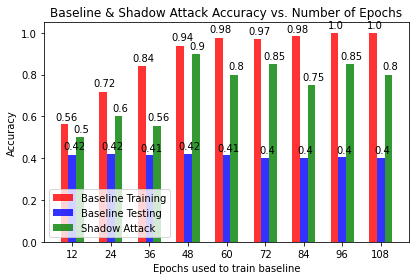

In [7]:
# data to plot
n_groups = 9
training_accuracy = (0.5624, 0.7189, 0.8405, 0.9385, 0.9772, 0.9715, 0.9849, 0.9999, 0.9999)
testing_accuracy = (0.4170, 0.4225, 0.4140, 0.4210, 0.4136, 0.4027, 0.4016, 0.4047, 0.4009)
shadow_accuracy = (0.4996, 0.6014, 0.5552, 0.9000, 0.8000, 0.8500, 0.7500, 0.8500, 0.8000)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, training_accuracy, bar_width,
alpha=opacity,
color='r',
label='Baseline Training')

rects2 = plt.bar(index + bar_width, testing_accuracy, bar_width,
alpha=opacity,
color='b',
label='Baseline Testing')

rects3 = plt.bar(index + bar_width * 2, shadow_accuracy, bar_width,
alpha=opacity,
color='g',
label='Shadow Attack')

plt.xlabel('Epochs used to train baseline')
plt.ylabel('Accuracy')
plt.title('Baseline & Shadow Attack Accuracy vs. Number of Epochs')
plt.xticks(index + bar_width, ('12', '24', '36', '48', '60', '72', '84', '96', '108'))
plt.legend(loc = 'lower left')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(3, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

Overfitting Ratio

In [16]:
ratio_of_overfitting = [training_accuracy[i]/testing_accuracy[i] for i in range(len(training_accuracy))]
print(np.asarray(ratio_of_overfitting).round(2))

[1.35 1.7  2.03 2.23 2.36 2.41 2.45 2.47 2.49]


Written Exercise 5 Code

In [19]:
# YOUR IMPLEMENTATION FOR THE SHADOW MODEL ATTACK GOES HERE ###################


def synthesize_attack_data(
    target_model: hw5_part1_utils.TargetModel,
    shadow_data: np.ndarray,
    shadow_labels: np.ndarray,
    num_shadow_models: int = 4
):
    """Synthesize attack data.

    Arguments:

        target_model {TargetModel} -- an instance of the TargetModel class;
          behaves as a keras model but additionally has a train_shadow_model
          function, which takes a subset of the shadow data and labels and
          returns a model with identical architecture and hyperparameters to
          the original target model, but that is trained on the given shadow
          data.

        shadow_data {np.ndarray} -- data available to the attack to train
          shadow models. If the arget model's training set is size N x D,
          shadow_data is 2N x D.

        shadow_labels {np.ndarray} -- the corresponding labels to the
          shadow_data, given as a numpy array of 2N integers in the range 0 to
          C where C is the number of classes.

        num_shadow_models {int} -- the number of shadow models to use when
          constructing the attack model's dataset.

    Returns: three np.ndarrays; let M = 2N * num_shadow_models

        attack_data {np.ndarray} [M, 2C] -- shadow data label probability and
           label one-hot

        attack_classes {np.ndarray} [M, 1 of {0,1,...,C-1}] -- shadow data
           labels

        attack_labels {np.ndarray} [M, 1 of {0,1}] -- attack data labels
           (training membership)

    """

    C = shadow_labels.max() + 1

    attack_data: np.ndarray = None
    attack_classes: np.ndarray = None
    attack_labels: np.ndarray = None

    # SOLUTION
    # raise NotImplementedError('You need to implement this.')

    in_data = []
    out_data = []
    shadow_data_classes = []

    for i in tqdm(
        range(num_shadow_models),
        desc="training shadow models",
        unit="split"
    ):

        split = hw5_part1_utils.DataSplit(shadow_labels, seed=i)

        shadow_model = target_model.train_shadow_model(
            shadow_data[split.in_idx], shadow_labels[split.in_idx],
            # shadow_data[split.out_idx], shadow_labels[split.out_idx]
            # validation data
        )

        in_pred = shadow_model.predict(shadow_data[split.in_idx])
        in_onehot = to_categorical(
            shadow_labels[split.in_idx], C
        )
        in_data.append(np.concatenate(
            (in_pred, in_onehot),
            axis=1)
        )

        out_pred = shadow_model.predict(shadow_data[split.out_idx])
        out_onehot = to_categorical(
            shadow_labels[split.out_idx], C
        )
        out_data.append(np.concatenate(
            (out_pred, out_onehot),
            axis=1)
        )
        shadow_data_classes.append(shadow_labels[split.in_idx])
        shadow_data_classes.append(shadow_labels[split.out_idx])

    in_data = np.concatenate(in_data)
    out_data = np.concatenate(out_data)

    attack_data = np.concatenate((in_data, out_data))

    attack_labels = np.concatenate((
        np.ones(len(in_data)),
        np.zeros(len(out_data)))
    )

    attack_classes = np.concatenate(shadow_data_classes)

    ###

    return attack_data, attack_classes, attack_labels


def build_attack_models(
    target_model: hw5_part1_utils.TargetModel,
    shadow_data: np.ndarray,
    shadow_labels: np.ndarray,
    num_shadow_models: int = 4,
    batch_size=2048,
    epochs=32
):
    """Build attacker models.

    Arguments:

        target_model {TargetModel} -- an instance of the TargetModel class;
          behaves as a keras model but additionally has a train_shadow_model
          function, which takes a subset of the shadow data and labels and
          returns a model with identical architecture and hyperparameters to
          the original target model, but that is trained on the given shadow
          data.

        shadow_data {np.ndarray} -- data available to the attack to train
          shadow models. If the arget model's training set is size N x D,
          shadow_data is 2N x D.

        shadow_labels {np.ndarray} -- the corresponding labels to the
          shadow_data, given as a numpy array of 2N integers in the range 0 to
          C where C is the number of classes.

        num_shadow_models {int} -- the number of shadow models to use when
          constructing the attack model's dataset.

    Returns:

        {tuple} -- a tuple of C keras models, where the c^th model predicts the
        probability that an instance of class c was a training set member.

    """

    attack_data, attack_classes, attack_labels = \
        synthesize_attack_data(
            target_model,
            shadow_data,
            shadow_labels,
            num_shadow_models=4
        )

    # to return
    attack_models: Tuple[Model] = None

    C = shadow_labels.max() + 1

    # SOLUTION
    # raise NotImplementedError('You need to implement this.')

    #Define the attack model architecture.
    def get_attack_model_architecture_1():
        attack_x = Input((2 * C,))
        attack_y = Dense(128, activation='relu')(attack_x)
        attack_y = Dense(64, activation='relu')(attack_y)
        attack_y = Dense(32, activation='relu')(attack_y)
        attack_y = Dense(10, activation='relu')(attack_y)
        attack_y = Dense(1, activation='sigmoid')(attack_y)

        attack_model = Model(attack_x, attack_y)

        attack_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return attack_model

        # Define the attack model architecture.
    def get_attack_model_architecture_2():
        attack_x = Input((2 * C,))
        attack_y = Dense(4 * C, activation='relu')(attack_x)
        attack_y = Dense(1, activation='sigmoid')(attack_y)

        attack_model = Model(attack_x, attack_y)

        attack_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return attack_model

        # Define the attack model architecture.
    def get_attack_model_architecture_3():
        attack_x = Input((2 * C,))
        attack_y = Dense(20, activation='relu')(attack_x)
        attack_y = Dense(20, activation='relu')(attack_y)
        attack_y = Dense(20, activation='relu')(attack_y)
        attack_y = Dense(20, activation='relu')(attack_y)
        attack_y = Dense(1, activation='sigmoid')(attack_y)

        attack_model = Model(attack_x, attack_y)

        attack_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return attack_model
    
        # Define the attack model architecture.
    def get_attack_model_architecture_4():
        attack_x = Input((2 * C,))
        attack_y = Dense(20, activation='relu')(attack_x)
        attack_y = Dense(16, activation='relu')(attack_x)
        attack_y = Dense(12, activation='relu')(attack_x)
        attack_y = Dense(8, activation='relu')(attack_x)
        attack_y = Dense(4, activation='relu')(attack_x)
        attack_y = Dense(2, activation='relu')(attack_x)
        attack_y = Dense(1, activation='sigmoid')(attack_y)

        attack_model = Model(attack_x, attack_y)

        attack_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return attack_model

        # Define the attack model architecture.
    def get_attack_model_architecture_5():
        attack_x = Input((2 * C,))
        attack_y = Dense(48, activation='relu')(attack_x)
        attack_y = Dropout(0.2)(attack_y)
        attack_y = Dense(48, activation='relu')(attack_y)
        attack_y = Dropout(0.2)(attack_y)
        attack_y = Dense(32, activation='relu')(attack_y)
        attack_y = Dropout(0.2)(attack_y)
        attack_y = Dense(16, activation='relu')(attack_y)
        attack_y = Dropout(0.2)(attack_y)
        attack_y = Dense(10, activation='relu')(attack_y)
        attack_y = Dropout(0.2)(attack_y)
        attack_y = Dense(1, activation='sigmoid')(attack_y)

        attack_model = Model(attack_x, attack_y)

        attack_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return attack_model

    # Train the attack model. We have one model per ground truth class.
    ret_models_1 = []
    ret_models_2 = []
    ret_models_3 = []
    ret_models_4 = []
    ret_models_5 = []
    for c in tqdm(range(C), desc="training attack models", unit="class"):
        attack_model_1 = get_attack_model_architecture_1()

        attack_model_1.fit(
            attack_data[attack_classes == c],
            attack_labels[attack_classes == c],
            batch_size=batch_size,
            verbose=0,
            epochs=epochs
        )

        ret_models_1.append(attack_model_1)

        attack_model_2 = get_attack_model_architecture_2()

        attack_model_2.fit(
            attack_data[attack_classes == c],
            attack_labels[attack_classes == c],
            batch_size=batch_size,
            verbose=0,
            epochs=epochs
        )

        ret_models_2.append(attack_model_2)

        attack_model_3 = get_attack_model_architecture_3()

        attack_model_3.fit(
            attack_data[attack_classes == c],
            attack_labels[attack_classes == c],
            batch_size=batch_size,
            verbose=0,
            epochs=epochs
        )

        ret_models_3.append(attack_model_3)

        attack_model_4 = get_attack_model_architecture_4()

        attack_model_4.fit(
            attack_data[attack_classes == c],
            attack_labels[attack_classes == c],
            batch_size=batch_size,
            verbose=0,
            epochs=epochs
        )

        ret_models_4.append(attack_model_4)

        attack_model_5 = get_attack_model_architecture_5()

        attack_model_5.fit(
            attack_data[attack_classes == c],
            attack_labels[attack_classes == c],
            batch_size=batch_size,
            verbose=0,
            epochs=epochs
        )

        ret_models_5.append(attack_model_5)

    attack_models_1 = tuple(ret_models_1)
    attack_models_2 = tuple(ret_models_2)
    attack_models_3 = tuple(ret_models_3)
    attack_models_4 = tuple(ret_models_4)
    attack_models_5 = tuple(ret_models_5)

    ###

    return attack_models_1, attack_models_2, attack_models_3, attack_models_4, attack_models_5
    # return attack_models_2


def evaluate_membership(attack_models, y_pred, y):
    """Evaluate the attacker about the membership inference

    Arguments:

        attack_model {tuple} -- a tuple of C keras models, where C is the
          number of classes.

        y_pred {np.ndarray} -- an N x C numpy array with the predictions of the
          model on the N instances we are performing the inference attack on.

        y {np.ndarray} -- the true labels for each of the instances given as a
          numpy array of N integers.

    Returns:

        {np.ndarray} -- an array of N floats in the range [0,1] representing
          the estimated probability that each of the N given instances is a
          training set member.

    """

    # To return
    preds: np.ndarray = None

    # SOLUTION
    # raise NotImplementedError('You need to implement this.')
    attack_in = np.concatenate((y_pred, to_categorical(y)), axis=1)

    preds = np.zeros(y.shape)

    for c in tqdm(range(len(attack_models)),
                  desc="evaluating submodels",
                  unit="class"):

        preds[y == c] = attack_models[c].predict(attack_in[y == c])[0]

    ###

    return preds

# YOU DO NOT NEED TO MODIFY THE REST OF THIS CODE. ############################


if __name__ == '__main__':
    # Load the dataset.
    data = hw5_part1_utils.CIFARData()

    # Make a target model for the dataset.
    target_model_epochs = [48]
    for i in range(len(target_model_epochs)):
        target_model = \
            hw5_part1_utils.CIFARModel(
                epochs=target_model_epochs[i],
                batch_size=2048,
                noload=True, # prevents loading an existing pre-trained target
                            # model
            ).init(
                data.train, data.labels_train,
                # data.test, data.labels_test # validation data
            )
        print("\nTarget Model Epochs: ", target_model_epochs[i])
        tqdm.write('Building attack model...')
        attack_models_1, attack_models_2, attack_models_3, attack_models_4, attack_models_5 = build_attack_models(
            target_model,
            data.shadow,
            data.labels_shadow
        )

        # tqdm.write('Building attack model...')
        # attack_models_2 = build_attack_models(
        #     target_model,
        #     data.shadow,
        #     data.labels_shadow
        # )

        tqdm.write('Evaluating target model...')
        y_pred_in = target_model.predict(data.train)
        y_pred_out = target_model.predict(data.test)

        tqdm.write('  Train Accuracy: {:.4f}'.format(
            (y_pred_in.argmax(axis=1) == data.labels_train).mean()))
        tqdm.write('  Test Accuracy:  {:.4f}'.format(
            (y_pred_out.argmax(axis=1) == data.labels_test).mean()))

        in_preds_1 = evaluate_membership(
            attack_models_1,
            y_pred_in,
            data.labels_train
        )
        out_preds_1 = evaluate_membership(
            attack_models_1,
            y_pred_out,
            data.labels_test
        )

        in_preds_2 = evaluate_membership(
            attack_models_2,
            y_pred_in,
            data.labels_train
        )
        out_preds_2 = evaluate_membership(
            attack_models_2,
            y_pred_out,
            data.labels_test
        )

        in_preds_3 = evaluate_membership(
            attack_models_3,
            y_pred_in,
            data.labels_train
        )
        out_preds_3 = evaluate_membership(
            attack_models_3,
            y_pred_out,
            data.labels_test
        )

        in_preds_4 = evaluate_membership(
            attack_models_4,
            y_pred_in,
            data.labels_train
        )
        out_preds_4 = evaluate_membership(
            attack_models_4,
            y_pred_out,
            data.labels_test
        )

        in_preds_5 = evaluate_membership(
            attack_models_5,
            y_pred_in,
            data.labels_train
        )
        out_preds_5 = evaluate_membership(
            attack_models_5,
            y_pred_out,
            data.labels_test
        )

        true_positives_1 = (in_preds_1 > 0.5).mean()
        true_negatives_1 = (out_preds_1 < 0.5).mean()
        attack_acc_1 = (true_positives_1 + true_negatives_1) / 2.

        attack_precision_1 = (in_preds_1 > 0.5).sum() / (
            (in_preds_1 > 0.5).sum() + (out_preds_1 > 0.5).sum()
        )

        true_positives_2 = (in_preds_2 > 0.5).mean()
        true_negatives_2 = (out_preds_2 < 0.5).mean()
        attack_acc_2 = (true_positives_2 + true_negatives_2) / 2.

        attack_precision_2 = (in_preds_2 > 0.5).sum() / (
            (in_preds_2 > 0.5).sum() + (out_preds_2 > 0.5).sum()
        )

        true_positives_3 = (in_preds_3 > 0.5).mean()
        true_negatives_3 = (out_preds_3 < 0.5).mean()
        attack_acc_3 = (true_positives_3 + true_negatives_3) / 2.

        attack_precision_3 = (in_preds_3 > 0.5).sum() / (
            (in_preds_3 > 0.5).sum() + (out_preds_3 > 0.5).sum()
        )

        true_positives_4 = (in_preds_4 > 0.5).mean()
        true_negatives_4 = (out_preds_4 < 0.5).mean()
        attack_acc_4 = (true_positives_4 + true_negatives_4) / 2.

        attack_precision_4 = (in_preds_4 > 0.5).sum() / (
            (in_preds_4 > 0.5).sum() + (out_preds_4 > 0.5).sum()
        )

        true_positives_5 = (in_preds_5 > 0.5).mean()
        true_negatives_5 = (out_preds_5 < 0.5).mean()
        attack_acc_5 = (true_positives_5 + true_negatives_5) / 2.

        attack_precision_5 = (in_preds_5 > 0.5).sum() / (
            (in_preds_5 > 0.5).sum() + (out_preds_5 > 0.5).sum()
        )


        wrongs_in = y_pred_in.argmax(axis=1) != data.labels_train
        wrongs_out = y_pred_out.argmax(axis=1) != data.labels_test


        # Compare to a baseline that merely guesses correct classified instances
        # are in and incorrectly classified instances are out.
        baseline_true_positives = \
            (y_pred_in.argmax(axis=1) == data.labels_train).mean()
        baseline_true_negatives = \
            (y_pred_out.argmax(axis=1) != data.labels_test).mean()
        baseline_attack_acc = \
            (baseline_true_positives + baseline_true_negatives) / 2.

        baseline_precision = \
            (y_pred_in.argmax(axis=1) == data.labels_train).sum() / (
                (y_pred_in.argmax(axis=1) == data.labels_train).sum() +
                (y_pred_out.argmax(axis=1) == data.labels_test).sum()
            )

        tqdm.write(
          f"\nBaseline True positive rate: {baseline_true_positives:0.4f}, " +
          f"Baseline true negative rate: {baseline_true_negatives:0.4f}"
        )

        tqdm.write(
          f"\nTrue positive 1 rate: {true_positives_1:0.4f}, " +
          f"true negative 1 rate: {true_negatives_1:0.4f}"
        )
    
        tqdm.write(
          f"Shadow Attack Accuracy 1: {attack_acc_1:0.4f}, precision 1: {attack_precision_1:0.4f} " +
          f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        )

        tqdm.write(
          f"\nTrue positive 2 rate: {true_positives_2:0.4f}, " +
          f"true negative 2 rate: {true_negatives_2:0.4f}"
        )
    
        tqdm.write(
          f"Shadow Attack Accuracy 2: {attack_acc_2:0.4f}, precision 2: {attack_precision_2:0.4f} " +
          f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        )

        tqdm.write(
          f"\nTrue positive 3 rate: {true_positives_3:0.4f}, " +
          f"true negative 3 rate: {true_negatives_3:0.4f}"
        )
    
        tqdm.write(
          f"Shadow Attack Accuracy 3: {attack_acc_3:0.4f}, precision 3: {attack_precision_3:0.4f} " +
          f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        )

        tqdm.write(
          f"\nTrue positive 4 rate: {true_positives_4:0.4f}, " +
          f"true negative 4 rate: {true_negatives_4:0.4f}"
        )
    
        tqdm.write(
          f"Shadow Attack Accuracy 4: {attack_acc_4:0.4f}, precision 4: {attack_precision_4:0.4f} " +
          f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        )

        tqdm.write(
          f"\nTrue positive 5 rate: {true_positives_5:0.4f}, " +
          f"true negative 5 rate: {true_negatives_5:0.4f}"
        )
    
        tqdm.write(
          f"Shadow Attack Accuracy 5: {attack_acc_5:0.4f}, precision 5: {attack_precision_5:0.4f} " +
          f"(baseline: {baseline_attack_acc:0.4f}, {baseline_precision:0.4f})"
        )

Training target model...


training shadow models:   0%|          | 0/4 [00:00<?, ?split/s]


Target Model Epochs:  48
Building attack model...


training attack models: 100%|██████████| 10/10 [05:14<00:00, 31.44s/class]


Evaluating target model...


evaluating submodels:   0%|          | 0/10 [00:00<?, ?class/s]

  Train Accuracy: 0.9359
  Test Accuracy:  0.4078


evaluating submodels: 100%|██████████| 10/10 [00:01<00:00,  8.98class/s]


Baseline True positive rate: 0.9359, Baseline true negative rate: 0.5922

True positive 1 rate: 0.9001, true negative 1 rate: 0.7000
Shadow Attack Accuracy 1: 0.8000, precision 1: 0.7500 (baseline: 0.7640, 0.6965)

True positive 2 rate: 0.8064, true negative 2 rate: 0.7000
Shadow Attack Accuracy 2: 0.7532, precision 2: 0.7289 (baseline: 0.7640, 0.6965)

True positive 3 rate: 1.0000, true negative 3 rate: 0.7000
Shadow Attack Accuracy 3: 0.8500, precision 3: 0.7692 (baseline: 0.7640, 0.6965)

True positive 4 rate: 0.9026, true negative 4 rate: 0.5000
Shadow Attack Accuracy 4: 0.7013, precision 4: 0.6435 (baseline: 0.7640, 0.6965)

True positive 5 rate: 1.0000, true negative 5 rate: 0.7000
Shadow Attack Accuracy 5: 0.8500, precision 5: 0.7692 (baseline: 0.7640, 0.6965)


Question 3

In [3]:
!pip install gensim json
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip GoogleNews-vectors-negative300.bin.gz
!mv GoogleNews-vectors-negative300.bin data

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json
--2020-05-15 06:40:39--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.38.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.38.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.9MB/s    in 96s     

2020-05-15 06:42:16 (16.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import gensim.models
import numpy as np
from sklearn.decomposition import PCA
import json
from tqdm import tqdm

Written Exercise 17 and 18 Code

In [5]:
class WordEmbeddingDebiaser:

    def __init__(self,
                 embedding_file_path,
                 definitional_file_path='./data/definitional_pairs.json',
                 equalize_file_path='./data/equalize_pairs.json',
                 gender_specific_file_path='./data/gender_specific_full.json'):

        self.model = gensim.models.KeyedVectors.load_word2vec_format(
            embedding_file_path, binary=True)

        # collect first 300000 words
        self.words = sorted([w for w in self.model.vocab],
                            key=lambda w: self.model.vocab[w].index)[:300000]

        # all vectors in an array (same order as self.words)
        self.vecs = np.array([self.model[w] for w in self.words])
        tqdm.write('vectors loaded')
        # should take 2-5 min depending on your machine

        self.n, self.d = self.vecs.shape

        # word to index dictionary
        self.w2i = {w: i for i, w in enumerate(self.words)}

        # Some relevant words sets required for debiasing
        with open(definitional_file_path, "r") as f:
            self.definition_pairs = json.load(f)

        with open(equalize_file_path, "r") as f:
            self.equalize_pairs = json.load(f)

        with open(gender_specific_file_path, "r") as f:
            self.gender_specific_words = json.load(f)
        self._normalize()

    # Some potentially helpful functions, you don't have to use/implement them.
    def _normalize(self):
        """
        normalize self.vecs
        """
        self.vecs /= np.linalg.norm(self.vecs, axis=1)[:, np.newaxis]

    def _drop(self, u, v):
        """
        remove a direction v from u
        """
        return u - v * u.dot(v) / v.dot(v)

    def w2v(self, word):
        """
        for a word, return its corresponding vector
        """
        return self.vecs[self.w2i[word]]

    def debias(self):
        self.gender_direction = self.identify_gender_subspace()
        self.neutralize()
        self.equalize()

    def identify_gender_subspace(self):
        """Using self.definitional_pairs to identify a gender axis (1 dimensional).

          Output: a gender direction using definitonal pairs

        ****Note****

         no other unimported packages listed above are allowed, please use
         numpy.linalg.svd for PCA

        """
        matrix = []
        for a, b in self.definition_pairs:
            center = (self.w2v(a) + self.w2v(b)) / 2
            matrix.append(self.w2v(a) - center)
            matrix.append(self.w2v(b) - center)
        matrix = np.array(matrix)
        # pca = PCA(n_components=10)
        # pca.fit(matrix)
        # gender_direction = pca.components_[0]
        u, s, v = np.linalg.svd(matrix)
        gender_direction = v[0, :]

        return gender_direction

        # raise NotImplementedError('You need to implement this.')

    def neutralize(self):
        """Performing the neutralizing step: projecting all gender neurtal words away
        from the gender direction

        No output, please adjust self.vecs

        """
        specific_set = set(self.gender_specific_words)
        for i, w in enumerate(self.words):
            if w not in specific_set:
                self.vecs[i] = self._drop(self.vecs[i], self.gender_direction)
        self._normalize()
        # raise NotImplementedError('You need to implement this.')

    def equalize(self):
        """Performing the equalizing step: make sure all equalized pairs are
        equaldistant to the gender direction.

        No output, please adapt self.vecs

        """
        for (a, b) in self.equalize_pairs:
            if (a in self.w2i and b in self.w2i):
                y = self._drop((self.w2v(a) + self.w2v(b)) / 2,
                               self.gender_direction)
                z = np.sqrt(1 - np.linalg.norm(y)**2)
                if (self.w2v(a) - self.w2v(b)).dot(self.gender_direction) < 0:
                    z = -z
                self.vecs[self.w2i[a]] = z * self.gender_direction + y
                self.vecs[self.w2i[b]] = -z * self.gender_direction + y
        self._normalize()
        # raise NotImplementedError('You need to implement this.')
        # pass
    def compute_analogy(self, w3, w1='woman', w2='man'):
        """input: w3, w1, w2, satifying the analogy w1: w2 :: w3 : w4

        output: w4(a word string) which is the solution to the analogy (w4 is
          constrained to be different from w1, w2 and w3)

        """
        diff = self.w2v(w2) - self.w2v(w1)
        vec = diff / np.linalg.norm(diff) + self.w2v(w3)
        vec = vec / np.linalg.norm(vec)
        if w3 == self.words[np.argsort(vec.dot(self.vecs.T))[-1]]:
            return self.words[np.argsort(vec.dot(self.vecs.T))[-2]]
        return self.words[np.argmax(vec.dot(self.vecs.T))]


if __name__ == '__main__':

    # Original Embedding

    we = WordEmbeddingDebiaser('./data/GoogleNews-vectors-negative300.bin')

    print('=' * 50)
    print('Original Embeddings')
    # she-he analogy evaluation
    w3s1 = [
        'her', 'herself', 'spokeswoman', 'daughter', 'mother', 'niece',
        'chairwoman', 'Mary', 'sister', 'actress'
    ]
    w3s2 = [
        'nurse', 'dancer', 'feminist', 'baking', 'volleyball', 'softball',
        'salon', 'blond', 'cute', 'beautiful'
    ]

    w4s1 = [we.compute_analogy(w3) for w3 in w3s1]
    w4s2 = [we.compute_analogy(w3) for w3 in w3s2]

    print('Appropriate Analogies')
    for w3, w4 in zip(w3s1, w4s1):
        print("'woman' is to '%s' as 'man' is to '%s'" % (w3, w4))

    print('Potentially Biased Analogies')
    for w3, w4 in zip(w3s2, w4s2):
        print("'woman' is to '%s' as 'man' is to '%s'" % (w3, w4))

    we.debias()

    print('=' * 50)
    print('Debiased  Embeddings')
    # she-he analogy evaluation
    w4s1 = [we.compute_analogy(w3) for w3 in w3s1]
    w4s2 = [we.compute_analogy(w3) for w3 in w3s2]

    print('Appropriate Analogies')
    for w3, w4 in zip(w3s1, w4s1):
        print("'woman' is to '%s' as 'man' is to '%s'" % (w3, w4))

    print('Potentially Biased Analogies')
    for w3, w4 in zip(w3s2, w4s2):
        print("'woman' is to '%s' as 'man' is to '%s'" % (w3, w4))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


vectors loaded
Original Embeddings
Appropriate Analogies
'woman' is to 'her' as 'man' is to 'his'
'woman' is to 'herself' as 'man' is to 'himself'
'woman' is to 'spokeswoman' as 'man' is to 'spokesman'
'woman' is to 'daughter' as 'man' is to 'son'
'woman' is to 'mother' as 'man' is to 'father'
'woman' is to 'niece' as 'man' is to 'nephew'
'woman' is to 'chairwoman' as 'man' is to 'chairman'
'woman' is to 'Mary' as 'man' is to 'Paul'
'woman' is to 'sister' as 'man' is to 'brother'
'woman' is to 'actress' as 'man' is to 'actor'
Potentially Biased Analogies
'woman' is to 'nurse' as 'man' is to 'medic'
'woman' is to 'dancer' as 'man' is to 'magician'
'woman' is to 'feminist' as 'man' is to 'anarchist'
'woman' is to 'baking' as 'man' is to 'roasting'
'woman' is to 'volleyball' as 'man' is to 'football'
'woman' is to 'softball' as 'man' is to 'baseball'
'woman' is to 'salon' as 'man' is to 'barber_shop'
'woman' is to 'blond' as 'man' is to 'burly'
'woman' is to 'cute' as 'man' is to 'goofy'


Written Exercise 19 Code

In [13]:
class WordEmbeddingDebiaser:

    def __init__(self,
                 embedding_file_path,
                 definitional_file_path='./data/definitional_pairs.json',
                 equalize_file_path='./data/equalize_pairs.json',
                 gender_specific_file_path='./data/gender_specific_full.json',
                 profession_specific_file_path = './data/profession_words.json'):

        self.model = gensim.models.KeyedVectors.load_word2vec_format(
            embedding_file_path, binary=True)

        # collect first 300000 words
        self.words = sorted([w for w in self.model.vocab],
                            key=lambda w: self.model.vocab[w].index)[:300000]

        # all vectors in an array (same order as self.words)
        self.vecs = np.array([self.model[w] for w in self.words])
        self.vecs_copy = self.vecs.copy()
        tqdm.write('vectors loaded')
        # should take 2-5 min depending on your machine

        self.n, self.d = self.vecs.shape

        # word to index dictionary
        self.w2i = {w: i for i, w in enumerate(self.words)}

        # Some relevant words sets required for debiasing
        with open(definitional_file_path, "r") as f:
            self.definition_pairs = json.load(f)

        with open(equalize_file_path, "r") as f:
            self.equalize_pairs = json.load(f)

        with open(gender_specific_file_path, "r") as f:
            self.gender_specific_words = json.load(f)

        with open(profession_specific_file_path, "r") as f:
            self.profession_specific_words = json.load(f)
        self._normalize()

    # Some potentially helpful functions, you don't have to use/implement them.
    def _normalize(self):
        """
        normalize self.vecs
        """
        self.vecs /= np.linalg.norm(self.vecs, axis=1)[:, np.newaxis]

    def _drop(self, u, v):
        """
        remove a direction v from u
        """
        return u - v * u.dot(v) / v.dot(v)

    def project(self, u, v):
        """
        calculate the bias by projecting words onto gender direction
        """
        vec = v * u.dot(v) / v.dot(v)
        return vec


    def w2v(self, word):
        """
        for a word, return its corresponding vector
        """
        return self.vecs[self.w2i[word]]

    def debias(self):
        self.gender_direction = self.identify_gender_subspace()
        before_debias_avg, _ = self.avg_bias_calc()
        self.neutralize()
        self.equalize()
        after_debias_avg, after_debias_dict = self.avg_bias_calc()
        return before_debias_avg, after_debias_avg, after_debias_dict
        # print('Average Bias Before: {}'.format(before_debias_avg))
        # print('Average Bias After: {}'.format(after_debias_avg))

    def identify_gender_subspace(self):
        """Using self.definitional_pairs to identify a gender axis (1 dimensional).

          Output: a gender direction using definitonal pairs

        ****Note****

         no other unimported packages listed above are allowed, please use
         numpy.linalg.svd for PCA

        """
        matrix = []
        for a, b in self.definition_pairs:
            center = (self.w2v(a) + self.w2v(b)) / 2
            matrix.append(self.w2v(a) - center)
            matrix.append(self.w2v(b) - center)
        matrix = np.array(matrix)
        # pca = PCA(n_components=10)
        # pca.fit(matrix)
        # gender_direction = pca.components_[0]
        u, s, v = np.linalg.svd(matrix)
        gender_direction = v[0, :]

        return gender_direction

        # raise NotImplementedError('You need to implement this.')

    def avg_bias_calc(self):
        '''Calculate the avg bias of a set of words on the gender space'''
        total_count = 0
        bias = 0
        bias_dict = {}
        for word in self.profession_specific_words:
            if word in self.words:
                word_vector = self.w2v(word)
                word_project = self.project(word_vector, self.gender_direction)
                word_bias = np.sum(np.absolute(word_project))
                bias_dict[word] = word_bias
                bias += word_bias
                total_count += 1
        avg_bias = bias/total_count
        bias_dict = {k: bias_dict[k] for k in sorted(bias_dict, key=bias_dict.get, reverse=True)}
        return avg_bias, bias_dict

    def neutralize(self):
        """Performing the neutralizing step: projecting all gender neurtal words away
        from the gender direction

        No output, please adjust self.vecs

        """
        specific_set = set(self.gender_specific_words)
        for i, w in enumerate(self.words):
            if w not in specific_set:
                self.vecs[i] = self._drop(self.vecs[i], self.gender_direction)
        self._normalize()
        # raise NotImplementedError('You need to implement this.')

    def equalize(self):
        """Performing the equalizing step: make sure all equalized pairs are
        equaldistant to the gender direction.

        No output, please adapt self.vecs

        """
        for (a, b) in self.equalize_pairs:
            if (a in self.w2i and b in self.w2i):
                y = self._drop((self.w2v(a) + self.w2v(b)) / 2,
                               self.gender_direction)
                z = np.sqrt(1 - np.linalg.norm(y)**2)
                if (self.w2v(a) - self.w2v(b)).dot(self.gender_direction) < 0:
                    z = -z
                self.vecs[self.w2i[a]] = z * self.gender_direction + y
                self.vecs[self.w2i[b]] = -z * self.gender_direction + y
        self._normalize()
        # raise NotImplementedError('You need to implement this.')
        # pass
    def compute_analogy(self, w3, w1='woman', w2='man'):
        """input: w3, w1, w2, satifying the analogy w1: w2 :: w3 : w4

        output: w4(a word string) which is the solution to the analogy (w4 is
          constrained to be different from w1, w2 and w3)

        """
        diff = self.w2v(w2) - self.w2v(w1)
        vec = diff / np.linalg.norm(diff) + self.w2v(w3)
        vec = vec / np.linalg.norm(vec)
        if w3 == self.words[np.argsort(vec.dot(self.vecs.T))[-1]]:
            return self.words[np.argsort(vec.dot(self.vecs.T))[-2]]
        return self.words[np.argmax(vec.dot(self.vecs.T))]


if __name__ == '__main__':

    # Original Embedding

    we = WordEmbeddingDebiaser('./data/GoogleNews-vectors-negative300.bin')

    print('=' * 50)
    print('Original Embeddings')
    # she-he analogy evaluation
    w3s1 = [
        'her', 'herself', 'spokeswoman', 'daughter', 'mother', 'niece',
        'chairwoman', 'Mary', 'sister', 'actress'
    ]
    w3s2 = [
        'nurse', 'dancer', 'feminist', 'baking', 'volleyball', 'softball',
        'salon', 'blond', 'cute', 'beautiful'
    ]

    w4s1 = [we.compute_analogy(w3) for w3 in w3s1]
    w4s2 = [we.compute_analogy(w3) for w3 in w3s2]

    print('Appropriate Analogies')
    for w3, w4 in zip(w3s1, w4s1):
        print("'woman' is to '%s' as 'man' is to '%s'" % (w3, w4))

    print('Potentially Biased Analogies')
    for w3, w4 in zip(w3s2, w4s2):
        print("'woman' is to '%s' as 'man' is to '%s'" % (w3, w4))

    before_debias_avg, after_debias_avg, after_debias_dict = we.debias()

    print('=' * 50)
    print('Debiased  Embeddings')
    # she-he analogy evaluation
    w4s1 = [we.compute_analogy(w3) for w3 in w3s1]
    w4s2 = [we.compute_analogy(w3) for w3 in w3s2]

    print('Appropriate Analogies')
    for w3, w4 in zip(w3s1, w4s1):
        print("'woman' is to '%s' as 'man' is to '%s'" % (w3, w4))

    print('Potentially Biased Analogies')
    for w3, w4 in zip(w3s2, w4s2):
        print("'woman' is to '%s' as 'man' is to '%s'" % (w3, w4))
    
    print('Average Bias Before: {}'.format(before_debias_avg))
    print('Average Bias After: {}'.format(after_debias_avg))
    print('Debiased Bias Dictionary: {}'.format(after_debias_dict))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


vectors loaded
Original Embeddings
Appropriate Analogies
'woman' is to 'her' as 'man' is to 'his'
'woman' is to 'herself' as 'man' is to 'himself'
'woman' is to 'spokeswoman' as 'man' is to 'spokesman'
'woman' is to 'daughter' as 'man' is to 'son'
'woman' is to 'mother' as 'man' is to 'father'
'woman' is to 'niece' as 'man' is to 'nephew'
'woman' is to 'chairwoman' as 'man' is to 'chairman'
'woman' is to 'Mary' as 'man' is to 'Paul'
'woman' is to 'sister' as 'man' is to 'brother'
'woman' is to 'actress' as 'man' is to 'actor'
Potentially Biased Analogies
'woman' is to 'nurse' as 'man' is to 'medic'
'woman' is to 'dancer' as 'man' is to 'magician'
'woman' is to 'feminist' as 'man' is to 'anarchist'
'woman' is to 'baking' as 'man' is to 'roasting'
'woman' is to 'volleyball' as 'man' is to 'football'
'woman' is to 'softball' as 'man' is to 'baseball'
'woman' is to 'salon' as 'man' is to 'barber_shop'
'woman' is to 'blond' as 'man' is to 'burly'
'woman' is to 'cute' as 'man' is to 'goofy'
